In [ ]:
##### Importing python libraries #########

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from keras.layers import BatchNormalization
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Lambda, Activation,Conv2D,MaxPooling2D,Dense,Flatten,Dropout

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from glob import glob


In [ ]:
IMAGE_SIZE = [256, 256]
Dataset_path = "Sample_dataset/lung_cancer/"  # Provide the dataset path here
random_seed = 290993

categories = os.listdir(Dataset_path)

In [ ]:
# Initialize an empty set to store unique cancer types
cancer_types = set()

# Function to load images and corresponding labels from specified categories
def load_images_and_labels(categories):
    """
    This function loads images and their corresponding labels from the specified categories.

    Args:
    categories (list): A list of folder names representing different cancer types.
                       Each folder contains images of the respective cancer type.

    Returns:
    img_lst (list): A list of images (as NumPy arrays) resized to 256x256.
    labels (list): A list of corresponding labels (cancer types) for each image.
    """

    img_lst = []   # List to store the loaded images
    labels = []    # List to store the corresponding labels (cancer types)

    # Loop through each category folder (cancer type)
    for category in categories:
        # Extract the cancer type from the category name (assuming format is 'cancer_type_something')
        index = category.index('_')
        cell = category[0:index]   # Cancer type
        cancer_types.add(cell)     # Add the cancer type to the set

        # Loop through the first 400 images in the folder
        for image_name in os.listdir(Dataset_path + "/" + category)[:400]:
            # Check if the file is a valid image with 'jpg' or 'jpeg' extension
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
                # Read the image using OpenCV
                img = cv2.imread(Dataset_path + "/" + category + "/" + image_name)

                # Convert the image color from BGR to RGB (as OpenCV loads images in BGR format)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Convert the image to PIL format and resize it to 256x256
                img_array = Image.fromarray(img, 'RGB')
                resized_img = img_array.resize((256, 256))

                # Append the resized image (as a NumPy array) to the image list
                img_lst.append(np.array(resized_img))

                # Append the corresponding cancer type label to the labels list
                labels.append(cell)

    # Return the loaded images and labels
    return img_lst, labels

# Load images and labels by calling the function
images, labels = load_images_and_labels(categories)

# Print the number of images and labels loaded
print("No. of images loaded =", len(images), "\nNo. of labels loaded =", len(labels))

# Print the data types of images and labels to verify
print(type(images), type(labels))


No. of images loaded =  1536 
No. of labels loaded =  1536
<class 'list'> <class 'list'>


In [ ]:
# Convert the set of unique cancer types into a list
lung_cancer_types_list = list(cancer_types)

# Print the list of lung cancer categories
print("List of lung cancer categories =", lung_cancer_types_list)

# Print the total number of unique lung cancer categories
print("\n\nNo. of lung cancer categories =", len(lung_cancer_types_list))


List of lung_cancer categories =  ['Small', 'Adenocarcinoma', 'Large', 'Squamous'] 

No. of lung_cancer categories =  4


In [ ]:
# Convert the list of images and labels into NumPy arrays for easier manipulation
images = np.array(images)
labels = np.array(labels)

# Convert image data type to float32 for compatibility with deep learning models
images = images.astype(np.float32)

# Convert labels to one-hot encoded format using LabelBinarizer
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

# Get the number of unique classes (cancer types)
n_classes = len(label_binarizer.classes_)

# Normalize the image pixel values by dividing by 255 (scaling them between 0 and 1)
images = images / 255

# Print the shape of the images array after normalization
print("Images shape after normalization =", images.shape)


Images shape after normalization =  (1536, 256, 256, 3)


In [ ]:
# Import the train_test_split function from scikit-learn to split the dataset
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
# test_size=0.2 means 20% of the data will be used for testing, and 80% for training
# random_state ensures reproducibility of the split using a specific seed value
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=random_seed)

# Print the shapes of the training and testing data for both images and labels
print("x_train shape =", x_train.shape)  # Shape of the training images
print("y_train shape =", y_train.shape)  # Shape of the training labels
print("\nx_test shape =", x_test.shape)  # Shape of the testing images
print("y_test shape =", y_test.shape)    # Shape of the testing labels


x_train shape =  (1228, 256, 256, 3)
y_train shape =  (1228, 4)

x_test shape =  (308, 256, 256, 3)
y_test shape =  (308, 4)


In [ ]:
# Initialize the VGG19 model with pre-trained weights from ImageNet
# input_shape=IMAGE_SIZE+[3] specifies the input image dimensions (IMAGE_SIZE + 3 color channels for RGB)
# weights='imagenet' loads the pre-trained weights from the ImageNet dataset
# include_top=False excludes the fully connected layers (top layers) to use the model as a feature extractor
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# Freeze all layers of the VGG19 model to prevent them from being trained
# This is done to use the pre-trained features from the VGG19 model without updating the weights during training
for layer in vgg.layers:
    layer.trainable = False


In [ ]:
# Display a summary of the VGG19 model architecture
# This will print out the details of each layer in the VGG19 model, including the output shapes and number of parameters
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# Use the pre-trained VGG19 model as a feature extractor to generate feature maps for the training dataset
# The model processes the training images (x_train) and extracts high-level features
feature_extractor = vgg.predict(x_train)

39/39 [==============================] - 786s 20s/step


In [ ]:
# Reshape the extracted features to flatten them for further processing
# feature_extractor.shape[0] is the number of samples
# -1 automatically calculates the appropriate number of features (flattening all dimensions except the first one)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)


In [ ]:
# Assign the reshaped features to a new variable for use with a Support Vector Machine (SVM) model
# x_svm will now contain the flattened features extracted from the VGG19 model, ready for classification or other tasks
x_svm = features

In [ ]:
# Import necessary modules from scikit-learn
from sklearn.svm import SVC              # Import Support Vector Classification (SVC) for SVM
from sklearn import preprocessing       # Import preprocessing utilities for data scaling
from sklearn.multiclass import OneVsRestClassifier  # Import OneVsRestClassifier for multi-class classification

# Initialize an SVM model with a linear kernel wrapped in a OneVsRestClassifier
# OneVsRestClassifier allows the SVM model to handle multi-class classification by fitting one classifier per class
svm_model = OneVsRestClassifier(SVC(kernel='linear'))


In [ ]:
# Train the SVM model using the flattened feature vectors (x_svm) and the training labels (y_train)
# This step fits the model to the data, allowing it to learn patterns and make predictions
svm_model.fit(x_svm, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [ ]:
# Use the trained VGG19 model to extract features from the test dataset (x_test)
# This generates feature maps for the test images
x_test_feature = vgg.predict(x_test)

# Reshape the extracted features to flatten them for consistency with the training features
# x_test_feature.shape[0] is the number of test samples
# -1 automatically calculates the appropriate number of features (flattening all dimensions except the first one)
x_test_features = x_test_feature.reshape(x_test_feature.shape[0], -1)

In [ ]:
# Use the trained SVM model to make predictions on the test features (x_test_features)
# This step generates class labels for the test data based on the learned model
prediction_svm = svm_model.predict(x_test_features)

In [ ]:
# Import metrics and functions from scikit-learn for model evaluation
from sklearn import metrics
from sklearn.metrics import precision_recall_curve  # For calculating precision-recall pairs
from sklearn.metrics import accuracy_score         # For calculating accuracy
from sklearn.metrics import precision_score        # For calculating precision
from sklearn.metrics import recall_score           # For calculating recall
from sklearn.metrics import f1_score               # For calculating F1 score
from sklearn.metrics import confusion_matrix       # For calculating the confusion matrix
from sklearn.metrics import classification_report  # For generating a detailed classification report

# Calculate and print the accuracy of the SVM model on the test set
print("Accuracy =", metrics.accuracy_score(y_test, prediction_svm))

# Calculate and print the weighted precision score
# Precision is the ratio of correctly predicted positive observations to the total predicted positives
precision = precision_score(y_test, prediction_svm, average='weighted')
print('Precision: %f' % precision)

# Calculate and print the weighted recall score
# Recall is the ratio of correctly predicted positive observations to all observations in the actual class
recall = recall_score(y_test, prediction_svm, average='weighted')
print('Recall: %f' % recall)

# Calculate and print the weighted F1 score
# F1 score is the weighted average of precision and recall
f1 = f1_score(y_test, prediction_svm, average='weighted')
print('F1 score: %f' % f1)

# Calculate and print the confusion matrix
# The confusion matrix compares the predicted labels with the actual labels
# Note: `.argmax(axis=1)` is used if labels are one-hot encoded
cm = confusion_matrix(y_test.argmax(axis=1), prediction_svm.argmax(axis=1))
print(cm)

Accuracy = 0.987012987012987
Precision: 1.000000
Recall: 0.987013
F1 score: 0.993310
[[91  0  0  0]
 [ 0 61  0  0]
 [ 0  0 88  0]
 [ 4  0  0 64]]


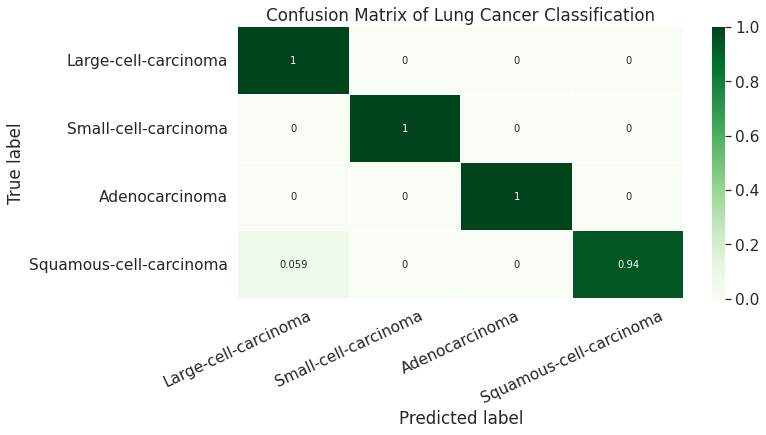

In [ ]:
# Calculate the confusion matrix and normalize it
# The confusion matrix is converted to a float type and normalized by dividing by the sum of each row
matrix = confusion_matrix(y_test.argmax(axis=1), prediction_svm.argmax(axis=1))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size and font scale for better readability
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.4)

# Create a heatmap of the normalized confusion matrix
# annot=True adds the numeric values to the heatmap cells
# annot_kws={'size':10} sets the font size of the annotations
# cmap=plt.cm.Greens specifies the color map
# linewidths=0.2 adds lines between cells for better separation
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

# Define class names for labeling the confusion matrix
class_names = ['Large-cell-carcinoma', 'Small-cell-carcinoma', 'Adenocarcinoma', 'Squamous-cell-carcinoma']
tick_marks = np.arange(len(class_names))
tick_mark2 = tick_marks + 0.5

# Set the tick labels and rotation for both x and y axes
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_mark2, class_names, rotation=0)

# Label the axes and set the title of the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix of Lung Cancer Classification')

# Display the plot
plt.show()

In [ ]:
# Print a detailed classification report for the SVM model's predictions
# The classification report includes precision, recall, F1 score, and support for each class
print(classification_report(y_test, prediction_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        88
           3       1.00      0.94      0.97        68

   micro avg       1.00      0.99      0.99       308
   macro avg       1.00      0.99      0.99       308
weighted avg       1.00      0.99      0.99       308
 samples avg       0.99      0.99      0.99       308



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
